In [1]:
import pandas
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

#distance
import gower

# x_reconstructed[self.binary_indices]
import importlib
import utils
importlib.reload(utils)

import models
importlib.reload(models)

import preprocessing
importlib.reload(preprocessing)
import torch
from torch import nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchsummary

from torch.utils.data import Dataset, DataLoader

sns.set_palette('Set2')

In [2]:
df = preprocessing.load_dataset()
data_tensor = torch.tensor(df.to_numpy(), dtype=torch.float32)
binary_indices = utils.binary_indices
continuous_indices = utils.continuous_indices

In [34]:
class DataFrameDataset(Dataset):
    def __init__(self, dataframe):
        # Assuming dataframe is already scaled and prepared for neural network input
        self.data = torch.tensor(dataframe.values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Returns a sample from the dataset
        return self.data[idx]
def create_dataloader(df, batch_size=32, shuffle=True):
    dataset = DataFrameDataset(df)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader
dataloader = create_dataloader(df, batch_size=10, shuffle=True)

In [35]:
model = models.Autoencoder(binary_indices = binary_indices)
torchsummary.summary(model);

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       352
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       136
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       36
├─Sequential: 1-2                        --
|    └─Linear: 2-6                       40
|    └─ReLU: 2-7                         --
|    └─Linear: 2-8                       144
|    └─ReLU: 2-9                         --
|    └─Linear: 2-10                      357
Total params: 1,065
Trainable params: 1,065
Non-trainable params: 0


In [36]:
model(torch.Tensor(21 * [0]).unsqueeze(0))

tensor([[ 0.0691,  0.4462,  0.5121,  0.4746,  0.5712,  0.5020,  0.4194,  0.5537,
          0.4046,  0.5707,  0.5680,  0.4466,  0.5024,  0.4773,  0.4113,  0.4329,
          0.0895, -0.1576, -0.0522, -0.2952,  0.0904]], grad_fn=<CopySlices>)

In [37]:
data = torch.tensor(df.to_numpy(), dtype=torch.float32)
binary_indices = torch.tensor(utils.binary_indices) 
# Calculate pos_weight for each binary feature
pos_weights = []
for idx in binary_indices:
    pos_count = (data[:, idx] == 1).sum().item()
    neg_count = (data[:, idx] == 0).sum().item()
    pos_weight = 1
    if pos_count > 0:
        pos_weight = neg_count / pos_count
    pos_weights.append(pos_weight)

# Convert to tensor
pos_weights = torch.tensor(pos_weights, dtype=torch.float32)
print("Calculated pos_weights:", pos_weights)

Calculated pos_weights: tensor([4.3741e-01, 1.5016e-01, 1.5658e-02, 1.2943e-02, 3.9861e-02, 1.0952e-02,
        1.4227e-02, 1.7093e-02, 7.0155e-02, 7.3826e-02, 1.2801e-02, 8.2621e-03,
        2.6226e-02, 1.3891e-04, 5.1402e-02])


In [38]:
epochs = 50
importlib.reload(utils)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=25, gamma=0.5)
#criterion = models.GowerLoss(binary_indices, continuous_indices)
#criterion = nn.L1Loss()
criterion = models.GowerLoss_Prob(binary_indices, 
                                  continuous_indices, 
                                  pos_weight=pos_weights)

for epoch in range(epochs):
    for data in dataloader:
        model.train()
        optimizer.zero_grad()
        x_reconstructed = model(data) 
        loss = criterion(x_reconstructed, data)
        loss.backward()
        optimizer.step()
        # Step the scheduler
    scheduler.step()
    if epoch % 20 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, LR: {scheduler.get_last_lr()[0]}')
print("Training complete")

Epoch [1/50], Loss: 0.0313, LR: 0.01
Epoch [21/50], Loss: 0.0234, LR: 0.01
Epoch [41/50], Loss: 0.0285, LR: 0.005
Training complete


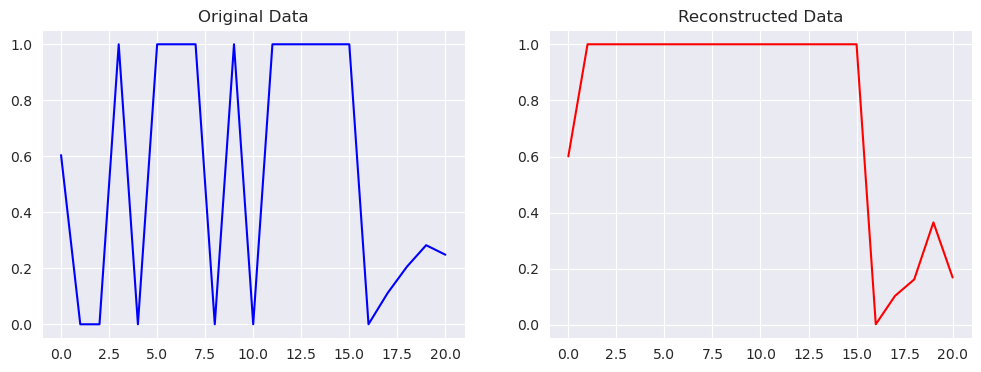

In [39]:
model.eval()
test_output = model(data_tensor)

index = 1
index = 1626
original_data = data_tensor.numpy()[index]
reconstructed_data = test_output.detach().numpy()[index]
#reconstructed_data[binary_indices] = (reconstructed_data[binary_indices] > 0.5)
reconstructed_data[binary_indices] = (reconstructed_data[binary_indices])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].plot(original_data, 'b')
axes[0].set_title('Original Data')
axes[1].plot(reconstructed_data, 'r')
axes[1].set_title('Reconstructed Data')
plt.show()

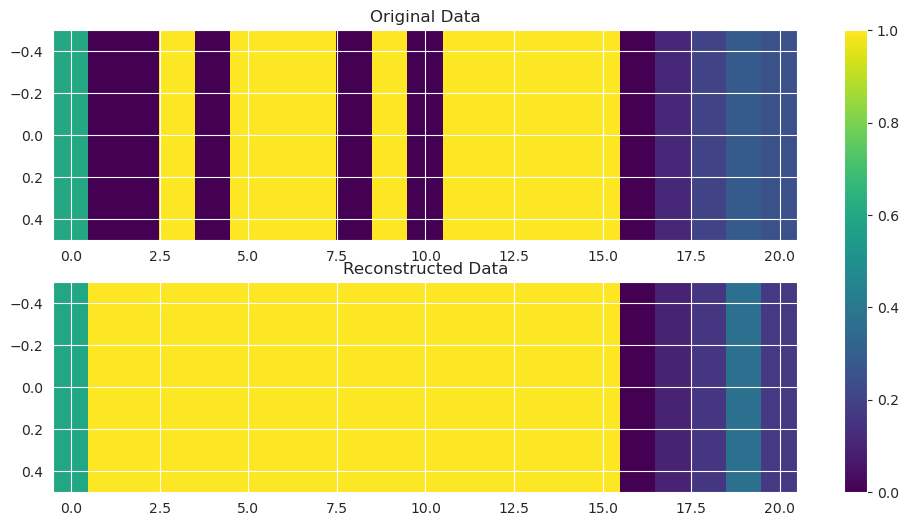

In [40]:
# Create the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))

# Reshape the 1D arrays to 2D (1 x number of elements)
original_data_2d = original_data.reshape(1, -1)
reconstructed_data_2d = reconstructed_data.reshape(1, -1)

# Heatmap for original data
cax1 = axes[0].imshow(original_data_2d, cmap='viridis', aspect='auto')
axes[0].set_title('Original Data')
# fig.colorbar(cax1, ax=axes[0])

# Heatmap for reconstructed data
cax2 = axes[1].imshow(reconstructed_data_2d, cmap='viridis', aspect='auto')
axes[1].set_title('Reconstructed Data')
# fig.colorbar(cax2, ax=axes[[1]])
fig.colorbar(cax1, ax=axes, orientation='vertical')
# Display the plot
plt.show()

In [194]:
distances = [utils.gower_dist(i , j,  utils.binary_indices, utils.continuous_indices) for i,j in zip(df, test_output)]

TypeError: string indices must be integers, not 'list'

In [195]:
plt.hist(distances, bins=12)

NameError: name 'distances' is not defined

In [196]:
plt.plot(np.sort(distances))

NameError: name 'distances' is not defined

In [ ]:
outlier_index = [-1 if i > 1.5 else 0 for i in distances]
print(f"percentage of outliers was set to: {-np.sum(outlier_index)/len(outlier_index) * 100: .2f}%")

In [ ]:
utils.plot_TSNE(df, outlier_index, dist_matrix=gower.gower_matrix(df))

In [ ]:
pd.concat([
    np.abs(np.sum((df[np.array(outlier_index) == -1]).iloc[:,binary_indices]-1,axis = 1)).describe(),
    np.abs(np.sum((df[np.array(outlier_index) != -1]).iloc[:,binary_indices]-1,axis = 1)).describe()], 
    axis = 1,
    keys = ['falses/obs Outliers', 'Falses/obs non-out']).iloc[2:,:]

In [ ]:
utils.plot_TSNE(df, outlier_index, dist_matrix=gower.gower_matrix(df))

In [ ]:
a = [criterion(data_tensor[0,:].unsqueeze(0), 
           data_tensor[i,:].unsqueeze(0)).item() for i in range(10)]

In [ ]:
b = np.array([utils.gower_dist(df.iloc[0,:].to_numpy(), df.iloc[i,:].to_numpy()) for i in range(10)])

In [ ]:
np.argmin(distances)

In [ ]:
distances[4911]

In [ ]:
np.argmax(distances)

In [ ]:
distances[1913]

In [ ]:
pd.DataFrame( distances).describe()

In [198]:
import random

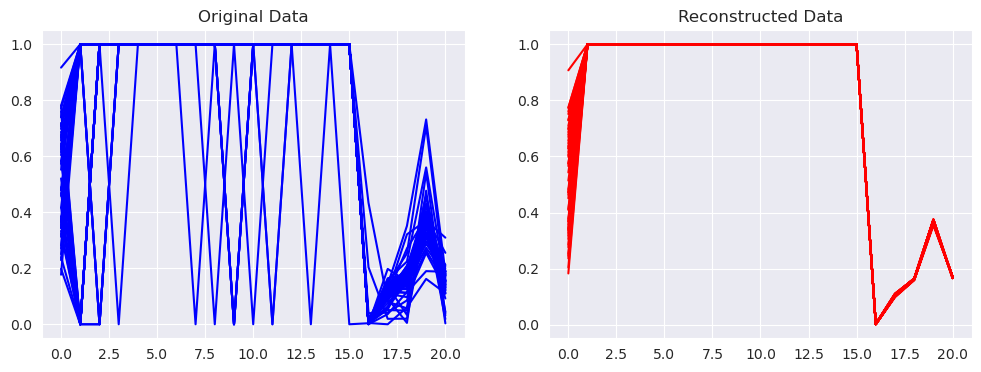

In [213]:
model.eval()
test_output = model(data_tensor)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

for i in random.sample(range(0, len(df)), 50):
    original_data = data_tensor.numpy()[i]
    reconstructed_data = test_output.detach().numpy()[i]
    #reconstructed_data[binary_indices] = (reconstructed_data[binary_indices] > 0.5)
    reconstructed_data[binary_indices] = (reconstructed_data[binary_indices])
    axes[0].plot(original_data, 'b')
    axes[0].set_title('Original Data')
    axes[1].plot(reconstructed_data, 'r')
    axes[1].set_title('Reconstructed Data')
plt.show()

In [219]:
binary_indices = utils.binary_indices
np.abs(np.sum(df.iloc[:,binary_indices] - 1, axis = 1)) >= 2

0        True
1       False
2       False
3       False
4       False
        ...  
7195    False
7196    False
7197    False
7198    False
7199    False
Length: 7200, dtype: bool

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7200 samples in 0.025s...
[t-SNE] Computed neighbors for 7200 samples in 0.498s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7200
[t-SNE] Computed conditional probabilities for sample 2000 / 7200
[t-SNE] Computed conditional probabilities for sample 3000 / 7200
[t-SNE] Computed conditional probabilities for sample 4000 / 7200
[t-SNE] Computed conditional probabilities for sample 5000 / 7200
[t-SNE] Computed conditional probabilities for sample 6000 / 7200
[t-SNE] Computed conditional probabilities for sample 7000 / 7200
[t-SNE] Computed conditional probabilities for sample 7200 / 7200
[t-SNE] Mean sigma: 0.003135
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.359283
[t-SNE] KL divergence after 1000 iterations: 0.974874


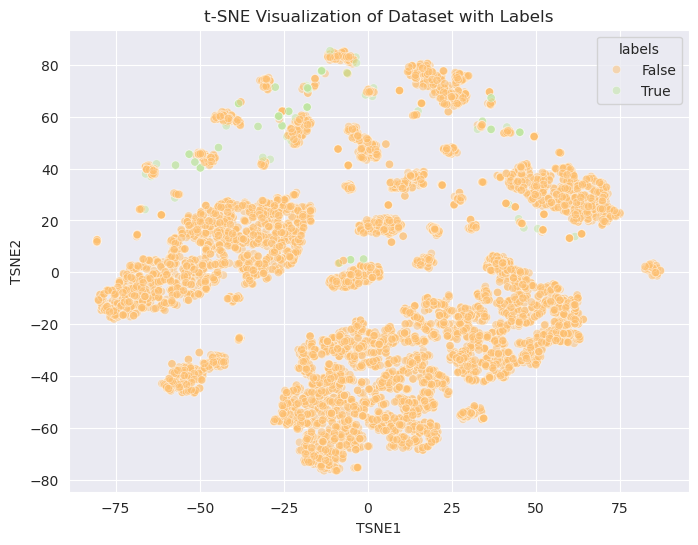

In [221]:
utils.plot_TSNE(df = df, labels = np.abs(np.sum(df.iloc[:,binary_indices] - 1, axis = 1)) == 3, 
                dist_matrix=gower.gower_matrix(df))

In [173]:
binary_indices = [0]
continuous_indices = [1]

x = torch.tensor([1.0, 1.0]).unsqueeze(0)
y = torch.tensor([0.5, 0.5]).unsqueeze(0)

bce = nn.BCELoss()
l1 = nn.L1Loss()

binary_loss = bce(x[:, binary_indices], y[:, binary_indices])
continuous_loss = l1(x[:, continuous_indices], y[:, continuous_indices])

combined_loss = (binary_loss + continuous_loss) / 2

print(f"binary_loss: {binary_loss.item()}, "
      f"continuous_loss: {continuous_loss.item()}, combined_loss: {combined_loss.item()}")



binary_loss: 50.0, continuous_loss: 0.5, combined_loss: 25.25


In [188]:
losses = []
for i in np.linspace(0.000001, 0.99999, 100):
    
    b = bce(i * torch.tensor([1.0, 1.0]).unsqueeze(0),
            torch.tensor([0.0000001, 0.00000001]).unsqueeze(0))
    c = l1(i * torch.tensor([1.0, 1.0]).unsqueeze(0),
            torch.tensor([0.0000001, 0.000000001]).unsqueeze(0))*2
    losses.append((b, c))


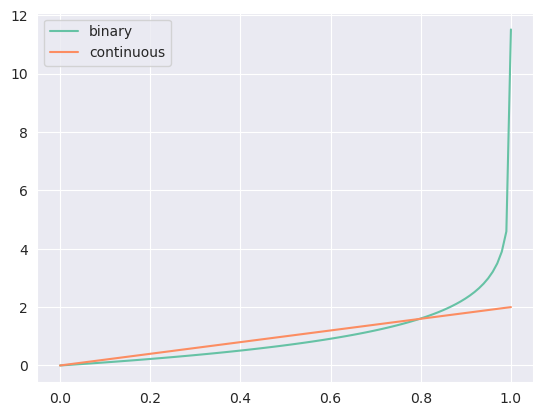

In [189]:
import matplotlib.pyplot as plt
plt.plot(np.linspace(0,1,100), [i[0].item() for i in losses], label='binary')
plt.plot(np.linspace(0,1,100), [i[1].item() for i in losses], label='continuous')
plt.legend()
plt.show()
